In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
filename = 'data/cleaned_data.csv'
df = pd.read_csv(filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   from_encounter             50401 non-null  int64  
 1   fishing_vessel_mmsi        10126 non-null  float64
 2   transshipment_vessel_mmsi  50401 non-null  int64  
 3   start_time                 50401 non-null  object 
 4   end_time                   50401 non-null  object 
 5   mean_latitude              50401 non-null  float64
 6   mean_longitude             50401 non-null  float64
 7   duration_hr                50401 non-null  float64
 8   median_distance_km         10126 non-null  float64
 9   median_speed_knots         50401 non-null  float64
 10  starting_timestamp         50401 non-null  float64
 11  ending_timestamp           50401 non-null  float64
 12  mmsi_t                     50401 non-null  float64
 13  shipname_t                 50401 non-null  obj

# Preprocessing

First we are taking a look at the correlation matrix

<AxesSubplot:>

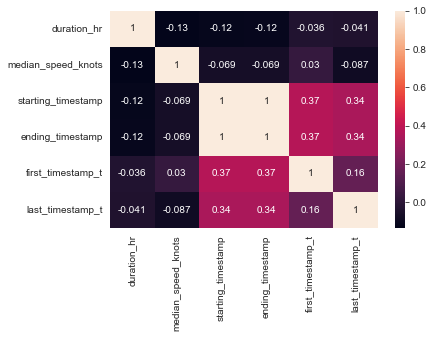

In [3]:
KMeans_input_columns = ['duration_hr', 'median_speed_knots','starting_timestamp', 'ending_timestamp', 'first_timestamp_t', 'last_timestamp_t'] # only select numerical features

sns.heatmap(df[KMeans_input_columns].corr(), annot=True)

We can observe that we have high correlations between starting_timestamp and ending_timestamp
So we are going to exclude: ending_timestamp

In [4]:
KMeans_input_columns.remove('ending_timestamp')  # exclude due to high correlations

scaler = StandardScaler()  # z-score standardization
standardized_df = pd.DataFrame(scaler.fit_transform(df[KMeans_input_columns]))  # standardize columns to have mean=0 and std=1 (+/- numerical errors)
standardized_df.rename(columns=dict(zip(list(standardized_df.columns),KMeans_input_columns)), inplace=True)  # column names are lost during standardization

# K-Means
Now we are ready to apply the k_Means alg on the data. But before continue with our analysis we have to decide which value of the k-parameter fits best. For this purpose, we are going to create an elbow plot.

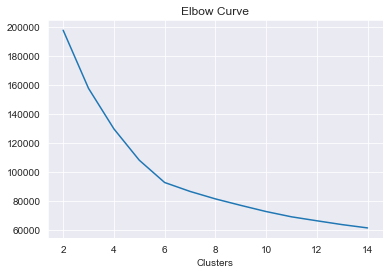

In [5]:
inertia_l = []  # Sum of squared distances of samples to their closest cluster center
for k in range(2,15):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=False).fit(standardized_df)
    inertia_l.append(kmeans.inertia_)

plt.plot(range(2, 15), inertia_l)
plt.title('Elbow Curve')
plt.xlabel('Clusters')
plt.show()

We will settle for k=6

In [6]:
k = 6
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=False).fit_predict(standardized_df)

In [7]:
standardized_df['Cluster'] = pd.DataFrame(kmeans)  # add cluster column to standardized dataset
df['Cluster'] = pd.DataFrame(kmeans)  # add cluster column to base (cleaned) dataset
standardized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   duration_hr         50401 non-null  float64
 1   median_speed_knots  50401 non-null  float64
 2   starting_timestamp  50401 non-null  float64
 3   first_timestamp_t   50401 non-null  float64
 4   last_timestamp_t    50401 non-null  float64
 5   Cluster             50401 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 2.1 MB


### Analysis

In the following we first take a look at the top five flags of the whole data set and after that at the top five flags of each cluster

Top five flags of the whole dataset

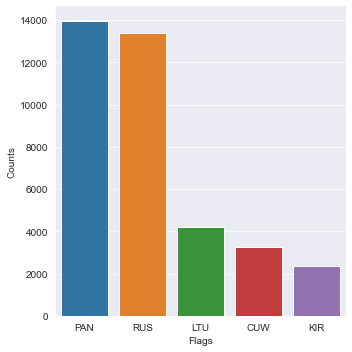

In [8]:
flags_counts = pd.DataFrame(sorted(zip(df['flag_t'].unique(),df['flag_t'].value_counts()), key=lambda x: x[1],reverse=True)[:5])
flags_counts.columns=['Flags','Counts']
sns.catplot(data=flags_counts,x='Flags',y='Counts',kind="bar")

Top five flags of each Cluster

Cluster 0


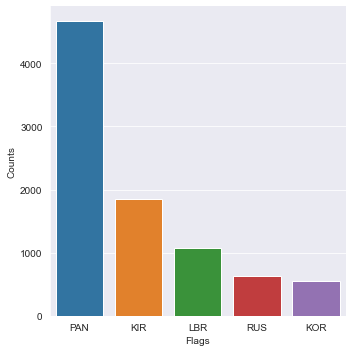

Cluster 1


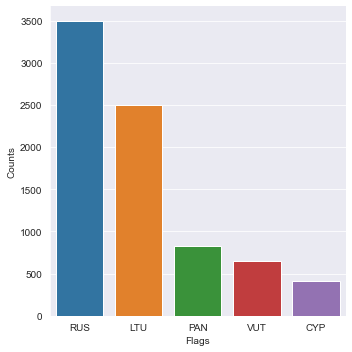

Cluster 2


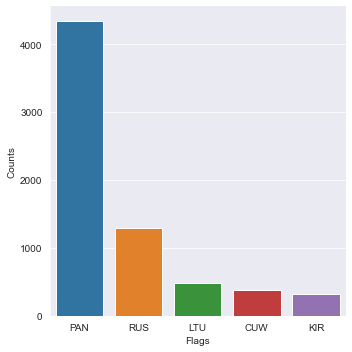

Cluster 3


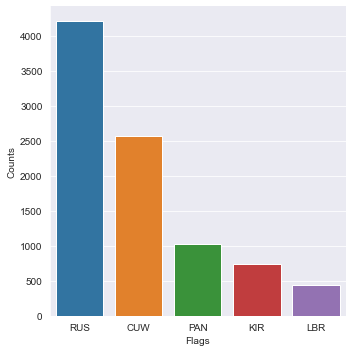

Cluster 4


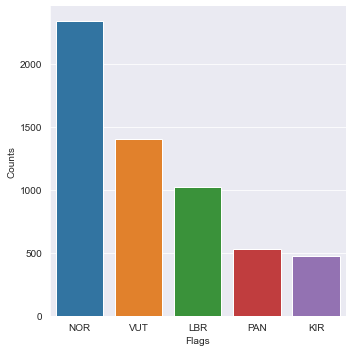

Cluster 5


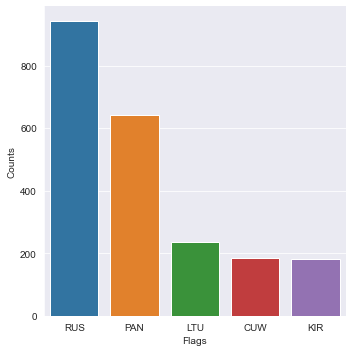

In [9]:
flags_cluster_list = [df[df['Cluster']==cluster]['flag_t'] for cluster in range(k)]  # list of flag_t columns per cluster from 0 to k


for cluster_nb, cluster_flags in enumerate(flags_cluster_list):
    flags_counts = pd.DataFrame(sorted(zip(cluster_flags.unique(),cluster_flags.value_counts()), key=lambda x: x[1],reverse=True)[:5])
    # select only top five
    flags_counts.columns=['Flags','Counts']
    print('Cluster {}'.format(cluster_nb))
    sns.catplot(data=flags_counts,x='Flags',y='Counts',kind="bar")
    plt.show()

### Output
We are saving the clustered dataset for later usage

In [10]:
df.to_csv('data/clustered_data.csv', index=False)

# PCA
Now we are going to perform a Principal Component Analysis looking at the first two principal components

In [11]:
pca = PCA(n_components=2)
pca.fit(standardized_df[KMeans_input_columns])
projected_data = pd.DataFrame(pca.transform(standardized_df[KMeans_input_columns]))
projected_data.rename(columns={0:'first_PC', 1: 'second_PC'}, inplace=True)

### Analysis

In [12]:
print('Explained variance by first principal: {:.1f} % \nExplained variance by second principal: {:.1f} % \nTotal: {:.1f} %'
      .format(pca.explained_variance_ratio_[0]*100, pca.explained_variance_ratio_[1]*100,
              pca.explained_variance_ratio_[0]*100 + pca.explained_variance_ratio_[1]*100 ))

Explained variance by first principal: 32.4 % 
Explained variance by second principal: 22.9 % 
Total: 55.3 %


In the following we are plotting the loading vectors of the first two principal components.

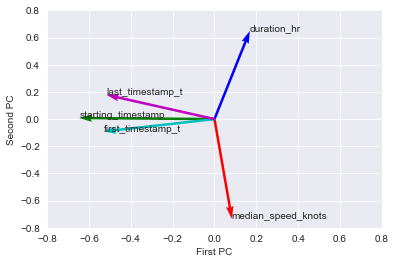

In [15]:
origin = np.zeros_like(pca.components_)  # point from where origin are drawn
plt.quiver(*origin, pca.components_[0], pca.components_[1],angles='xy', scale=1,scale_units='xy', color=('b','r','g','c','m','y','orange'))  # plot loading vectors

plt.xlim([-0.8,0.8])
plt.ylim([-0.8,0.8])
plt.xlabel('First PC')
plt.ylabel('Second PC')

# annotates entries of loading vectors (which are the input features)
for i, feature in enumerate(KMeans_input_columns):
    plt.annotate(feature, (pca.components_[0][i],pca.components_[1][i]))

It seems that the first principal component is putting a lot of weight on the coordinates. This comes as no surprise since the geodata of the dataset is not constrained to any particular region
The second pc puts most of its weight on the timestamps, both from the recorded events (starting_timestamp) and the time the vessels have been recorded in general (first and last timestamp).

Now we are going to project the data onto the first two principal components

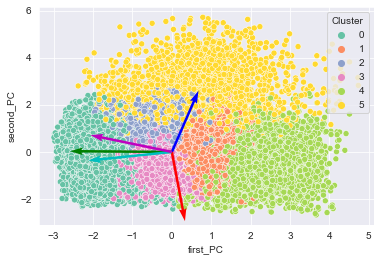

In [14]:
origin = np.zeros_like(pca.components_)

sns.scatterplot(x=projected_data['first_PC'],y=projected_data['second_PC'], hue=standardized_df['Cluster'], palette='Set2')
plt.quiver(*origin, pca.components_[0], pca.components_[1],angles='xy', scale=0.25,scale_units='xy', color=('b','r','g','c','m','y','orange'))